# Implementação em Python

## Imports

In [1]:
import serial
import numpy as np, matplotlib.pyplot as plt, biosppy as bp
from serial.tools.list_ports import comports
from biosppy.signals import tools as st
from pyautogui import click, position, moveTo
from datetime import datetime

## Functions

### Helper Functions

In [2]:
#Gets the arduino port
def find_arduino(index=0):
    """Get the name of the port that is connected to Arduino."""
    ports = comports()
    print(ports)
    for p in ports:
            port = p.device
            print(port)

find_arduino()

[<serial.tools.list_ports_common.ListPortInfo object at 0x11b7bab90>, <serial.tools.list_ports_common.ListPortInfo object at 0x117afe850>]
/dev/cu.Bluetooth-Incoming-Port
/dev/cu.usbserial-AB0ON6W5


In [70]:
#According to the input, it moves the mouse
def moveMouse(baselines, values, offsets, bools, times, speeds):
    
    #Unpacks the variables
    baseline_x, baseline_y, baseline_z = baselines
    x, y, z = values
    movOff, calOff, reduntOff = offsets
    calibrated, shown = bools
    timeCalibrated, time = times
    moveSpeed, maxMoveSpeed, aceleration, initialSpeed = speeds
    initialPosition = position()
    
    if(y < baseline_y - movOff and z < baseline_z - reduntOff): moveTo(None, position()[1] + moveSpeed)
    if(y > baseline_y + movOff and z < baseline_z - reduntOff): moveTo(None , position()[1] - moveSpeed)
    if(x < baseline_x - movOff and z < baseline_z - reduntOff): moveTo(position()[0] - moveSpeed, None)
    if(x > baseline_x + movOff and z < baseline_z - reduntOff): moveTo(position()[0] + moveSpeed, None)
    if(z > baseline_z + calOff): 
        calibrated = False
        shown = False
        timeCalibrated = time + 5000
    
    if(moveSpeed*aceleration < maxMoveSpeed and initialPosition != position()):
        moveSpeed = moveSpeed*aceleration
    elif (initialPosition == position()): moveSpeed = initialSpeed
        
    #Prepare variables for next send
    speeds = [moveSpeed, maxMoveSpeed, aceleration, initialSpeed]
    bools = [calibrated, shown]
    times = [timeCalibrated, time]

    return bools, times, speeds

In [71]:
#Recieves the data from the arduino and procedes to move the mouse
def defaultMouse(data_str, timeCalibrated, arduino, file, bools, stores, offsets, baselines, filteringInfo, 
                 speeds):
    #Unpacks Variables
    time, x, y, z = map(int, data_str.split(","))
    numSamples, numSamplesz, currentIndex, currentIndexz, samplesx, averagex, samplesy, averagey, samplesz, averagez = filteringInfo
    calibrated, shown = bools
    store_x, store_y, store_z = stores
    movOff, calOff, reduntOff = offsets
    baseline_x, baseline_y, baseline_z = baselines

    averagex -= samplesx[currentIndex]
    samplesx[currentIndex] = x
    averagex += samplesx[currentIndex]
    averagey -= samplesy[currentIndex]
    samplesy[currentIndex] = y
    averagey += samplesy[currentIndex]
    
    averagez -= samplesz[currentIndexz]
    samplesz[currentIndexz] = z
    averagez += samplesz[currentIndexz]
    
    currentIndex = (currentIndex + 1) % numSamples
    currentIndexz = (currentIndexz + 1) % numSamplesz

                
    if(time < timeCalibrated and not calibrated and not shown):
        print("Calibrating...")
        arduino.write(str(1).encode('utf-8'))
        shown = True
    elif(time < timeCalibrated and not calibrated):
        store_x = store_x + [x]
        store_y = store_y + [y]
        store_z = store_z + [z]
    elif (time > timeCalibrated and not calibrated):
        calibrated = True
        arduino.write(str(0).encode('utf-8'))
        baseline_x = np.mean(store_x)
        baseline_y = np.mean(store_y)
        baseline_z = np.mean(store_z)
        print("Calibrated: ", baseline_x, baseline_y, baseline_z)
        
    x = averagex / numSamples
    y = averagey / numSamples
    z = averagez / numSamplesz
    
    #Prepare variables for next send
    stores = [store_x, store_y, store_z]
    bools = [calibrated, shown]
    baselines = [baseline_x, baseline_y, baseline_z]
    filteringInfo = [numSamples, numSamplesz, currentIndex, currentIndexz, samplesx, 
                     averagex, samplesy, averagey, samplesz, averagez]
    times = [timeCalibrated, time]
    bools = [calibrated, shown]

    if(calibrated):
        bools, times, speeds = moveMouse(baselines,[x,y,z], offsets, bools, times, speeds)

    np.savetxt(file, [[time, x, y, z, position()[0], position()[1]]], delimiter=", ", fmt='%s')
    
    return times, stores, bools, baselines, filteringInfo, speeds

"/dev/cu.usbserial-AB0ON6W5"

### Main Functions

In [116]:
def extractData(port, baud_rate=9600, movOff=25, calOff=15, reduntOff=10, timeCalibrated=5000, moveSpeed=5, 
                maxMoveSpeed=100, aceleration=1.1):
    #Variable Assign
    arduino = serial.Serial(port, baud_rate, timeout=1)
    stores = [[],[],[]]
    testing = False
    testingValue = 0
    baselines = [0,0,0]
    bools = [False,False]
    offsets = [movOff, calOff, reduntOff]
    speeds = [moveSpeed, maxMoveSpeed, aceleration, moveSpeed]
    
    #Filtering Info
    numSamples, numSamplesz = 3, 3
    samplesx, samplesy = np.zeros(numSamples, dtype=int), np.zeros(numSamples, dtype=int)
    samplesz = np.zeros(numSamplesz, dtype=int)
    currentIndex, currentIndexz = 0, 0
    averagex, averagey, averagez = 0, 0, 0
    filteringInfo = [numSamples, numSamplesz, currentIndex, currentIndexz, samplesx, averagex, samplesy, 
                     averagey, samplesz, averagez]
    
    #File creation
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
    file = open(f"sensor_data_{dt_string}.txt", "a")
    time = 0
    
    #Arduino extract information
    try:
        while time < 60000:
            data_str = arduino.readline().decode('utf-8').strip()
            if (data_str == "Click"): click()
            elif (data_str == "RClick"): click(button='right')
            elif (data_str and not testing):
                times, stores, bools, baselines, filteringInfo, speeds = defaultMouse(data_str, timeCalibrated, 
                                                                                             arduino, file, bools, 
                                                                                             stores, offsets, 
                                                                                             baselines, 
                                                                                             filteringInfo, speeds)
                timeCalibrated, time = times
    except KeyboardInterrupt:
        print("Closing the serial port.")
        arduino.close()

    except Exception as e:
        print(f"Closing the serial port due to {e}.")
        arduino.close()

In [118]:
extractData("/dev/cu.usbserial-AB0ON6W5", aceleration=1, moveSpeed=15)

Calibrating...
Calibrated:  384.7142857142857 385.0 469.14285714285717
Calibrating...
Calibrated:  393.14285714285717 393.5 475.2857142857143
Calibrating...
Calibrated:  391.95238095238096 389.95238095238096 473.3333333333333


In [121]:
def loadData(fileName, samplingFrequency, baseline_x, baseline_y, baseline_z, band='lowpass', cutoffFrequency=50, 
             ftype='FIR', interval=[0,54000],movOff = 25, calOff = 15, reduntOff = 10):
    extractedData = np.loadtxt(fileName, delimiter=",")
    size = len(extractedData)
    time = []
    xValue, yValue, zValue = [[],[],[]]
    xPos, yPos = [[],[]]
    ftype = 'FIR'
    order = int(0.3*samplingFrequency)
    cMax = 446.5315316259553
    cMin = 297.26060334050584
    
    for i in range(size):
        time = time + [extractedData[i][0]]
        xValue = xValue + [extractedData[i][1]]
        yValue = yValue + [extractedData[i][2]]
        zValue = zValue + [extractedData[i][3]]
        xPos = xPos + [extractedData[i][4]]
        yPos = yPos + [extractedData[i][5]]
    
    xFrequencies, xPower = bp.signals.tools.welch_spectrum(xValue, samplingFrequency)
    yFrequencies, yPower = bp.signals.tools.welch_spectrum(yValue, samplingFrequency)
    zFrequencies, zPower = bp.signals.tools.welch_spectrum(zValue, samplingFrequency)
    
    xFiltered, _, _ = bp.signals.tools.filter_signal(xValue, ftype, band, order, 
                                                        cutoffFrequency, samplingFrequency)
    yFiltered, _, _ = bp.signals.tools.filter_signal(yValue, ftype, band, order, 
                                                        cutoffFrequency, samplingFrequency)
    zFiltered, _, _ = bp.signals.tools.filter_signal(zValue, ftype, band, order, 
                                                        cutoffFrequency, samplingFrequency)
    
    xFrequencies_Filtered, xPower_Filtered = bp.signals.tools.welch_spectrum(xFiltered, samplingFrequency)
    yFrequencies_Filtered, yPower_Filtered = bp.signals.tools.welch_spectrum(yFiltered, samplingFrequency)
    zFrequencies_Filtered, zPower_Filtered = bp.signals.tools.welch_spectrum(zFiltered, samplingFrequency)
    
    xCalibrated = ((np.array(xFiltered)-cMin)/(cMax-cMin))*2-1
    yCalibrated = ((np.array(yFiltered)-cMin)/(cMax-cMin))*2-1
    zCalibrated = ((np.array(zFiltered)-cMin)/(cMax-cMin))*2-1
    
    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
        
    ax[0,0].set_title("Raw Signal Extracted")
    ax[0,0].plot(time, xValue, color='r', label='X')
    ax[0,0].plot(time, yValue, color='b', label='Y')
    ax[0,0].plot(time, zValue, color='black', label='Z')
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('Value')
    ax[0,0].legend()
    ax[0,0].set_xlim(interval)
    
    ax[0,1].set_title("Power Spectral Density - Raw Signal")
    ax[0,1].plot(xFrequencies, xPower, color='r', label='X')
    ax[0,1].plot(yFrequencies, yPower, color='b', label='Y')
    ax[0,1].plot(zFrequencies, zPower, color='black', label='Z')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Frequency')
    ax[0,1].set_ylabel('Power')          
    
    """
    ax[1,0].set_title("Filtered Signal")
    ax[1,0].plot(time, xFiltered, color='r', label='X')
    ax[1,0].plot(time, yFiltered, color='b', label='Y')
    ax[1,0].plot(time, zFiltered, color='black', label='Z')
    ax[1,0].set_xlabel('Time')
    ax[1,0].set_ylabel('Value')
    ax[1,0].legend()
    ax[1,0].set_xlim(interval)
    
    ax[1,1].set_title("Power Spectral Density - Filtered Signal")
    ax[1,1].plot(xFrequencies_Filtered, xPower_Filtered, color='r', label='X')
    ax[1,1].plot(yFrequencies_Filtered, yPower_Filtered, color='b', label='Y')
    ax[1,1].plot(zFrequencies_Filtered, zPower_Filtered, color='black', label='Z')
    ax[1,1].legend()
    ax[1,1].set_xlabel('Frequency')
    ax[1,1].set_ylabel('Power')
    """
    
    ax[1,0].set_title("Calibrated Signal")
    ax[1,0].plot(time, xCalibrated, color='r', label='X')
    ax[1,0].plot(time, yCalibrated, color='b', label='Y')
    ax[1,0].plot(time, zCalibrated, color='black', label='Z')
    ax[1,0].set_xlabel('Time')
    ax[1,0].set_ylabel('Value')
    ax[1,0].legend()
    ax[1,0].set_xlim(interval)
    
    ax[1,1].set_title("Mouse Location")
    ax[1,1].plot(time, (np.array(xPos)/1469)*5-2, color='r', label="X_POS")
    ax[1,1].plot(time, (np.array(yPos)/955)*5-2, color='b', label="Y_POS")
    ax[1,1].plot(time, xCalibrated, color='r', label='X', alpha = 0.2)
    ax[1,1].plot(time, yCalibrated, color='b', label='Y', alpha = 0.2)
    ax[1,1].plot(time, zCalibrated, color='black', label='Z', alpha = 0.2)
    ax[1,1].set_xlabel('Time')
    ax[1,1].legend()
    ax[1,1].set_xlim(interval)    
    ax[1,1].set_ylabel('Position')
    
    fig.suptitle('Siganl Study and Processing', fontsize=16)
    plt.tight_layout()
    
    print("Session duration: ", time[size-1]/(10**(3)), "seconds")

Session duration:  60.028 seconds


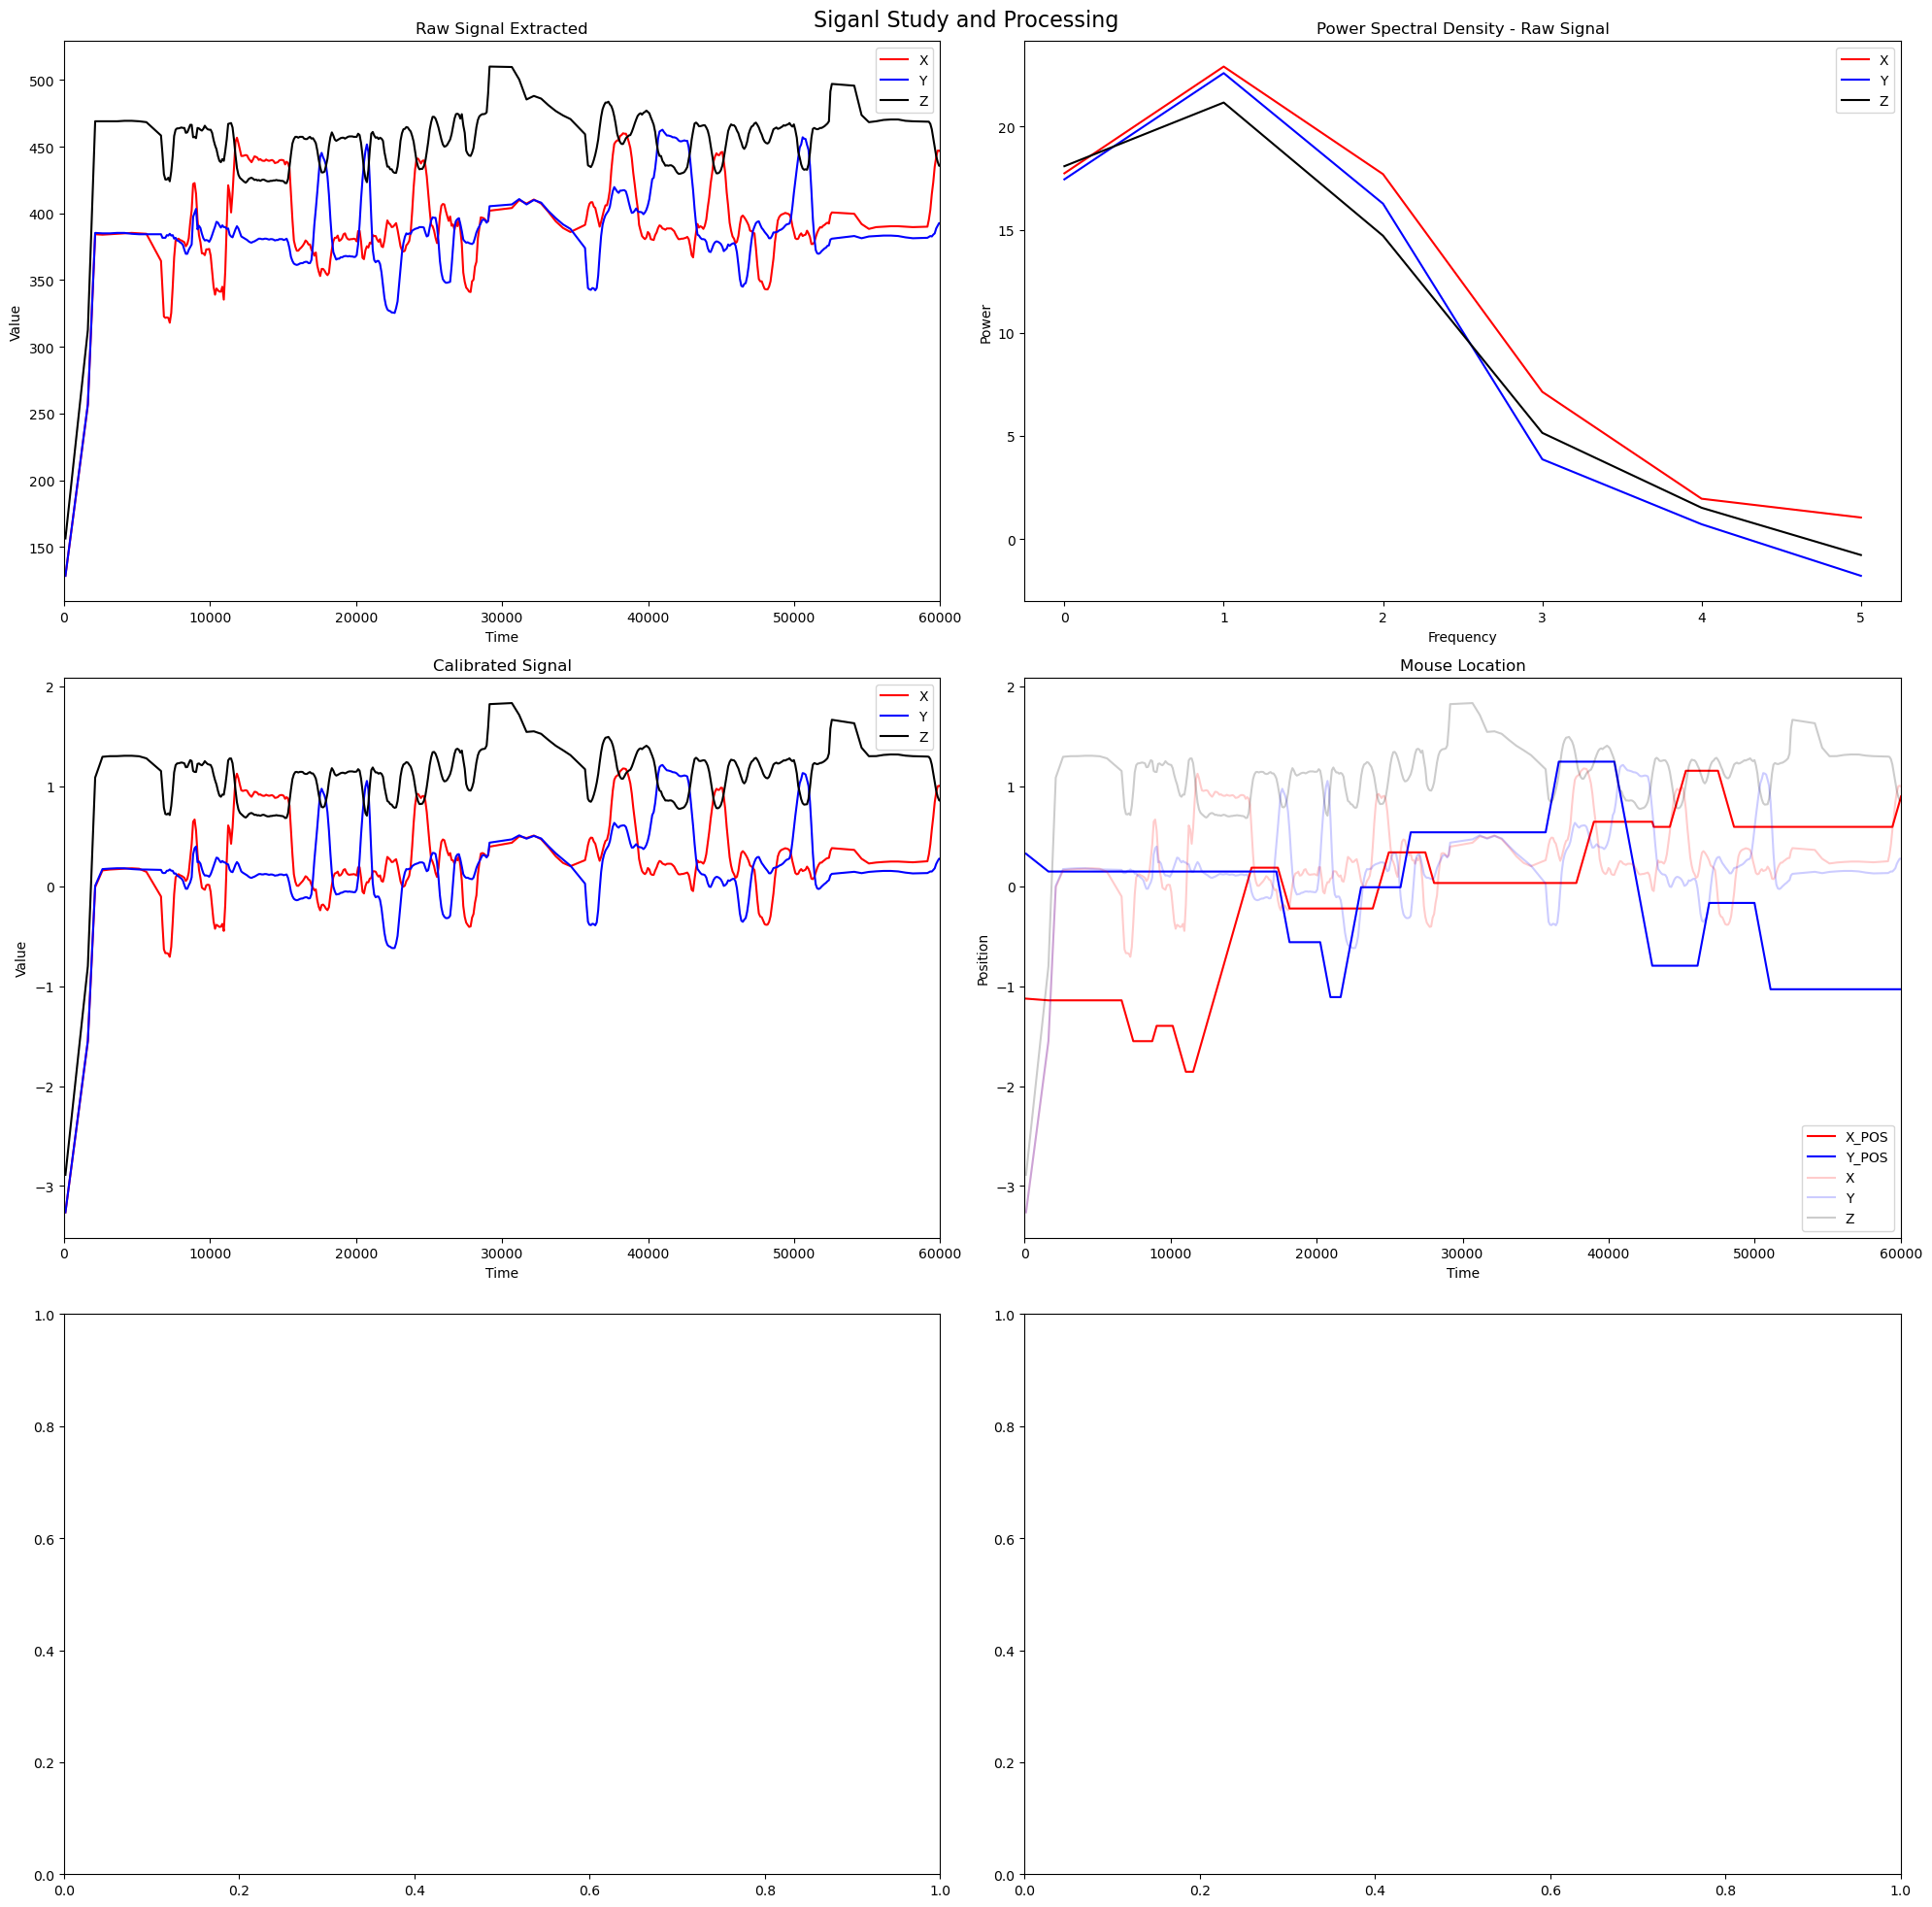

In [122]:
loadData("sensor_data_29-10-2023_19-15-12.txt", 10, 363.42857142857144, 391.14285714285717, 452.2857142857143, 
         cutoffFrequency=2,band='lowpass' ,interval=[0,60000])

Session duration:  60.0 seconds


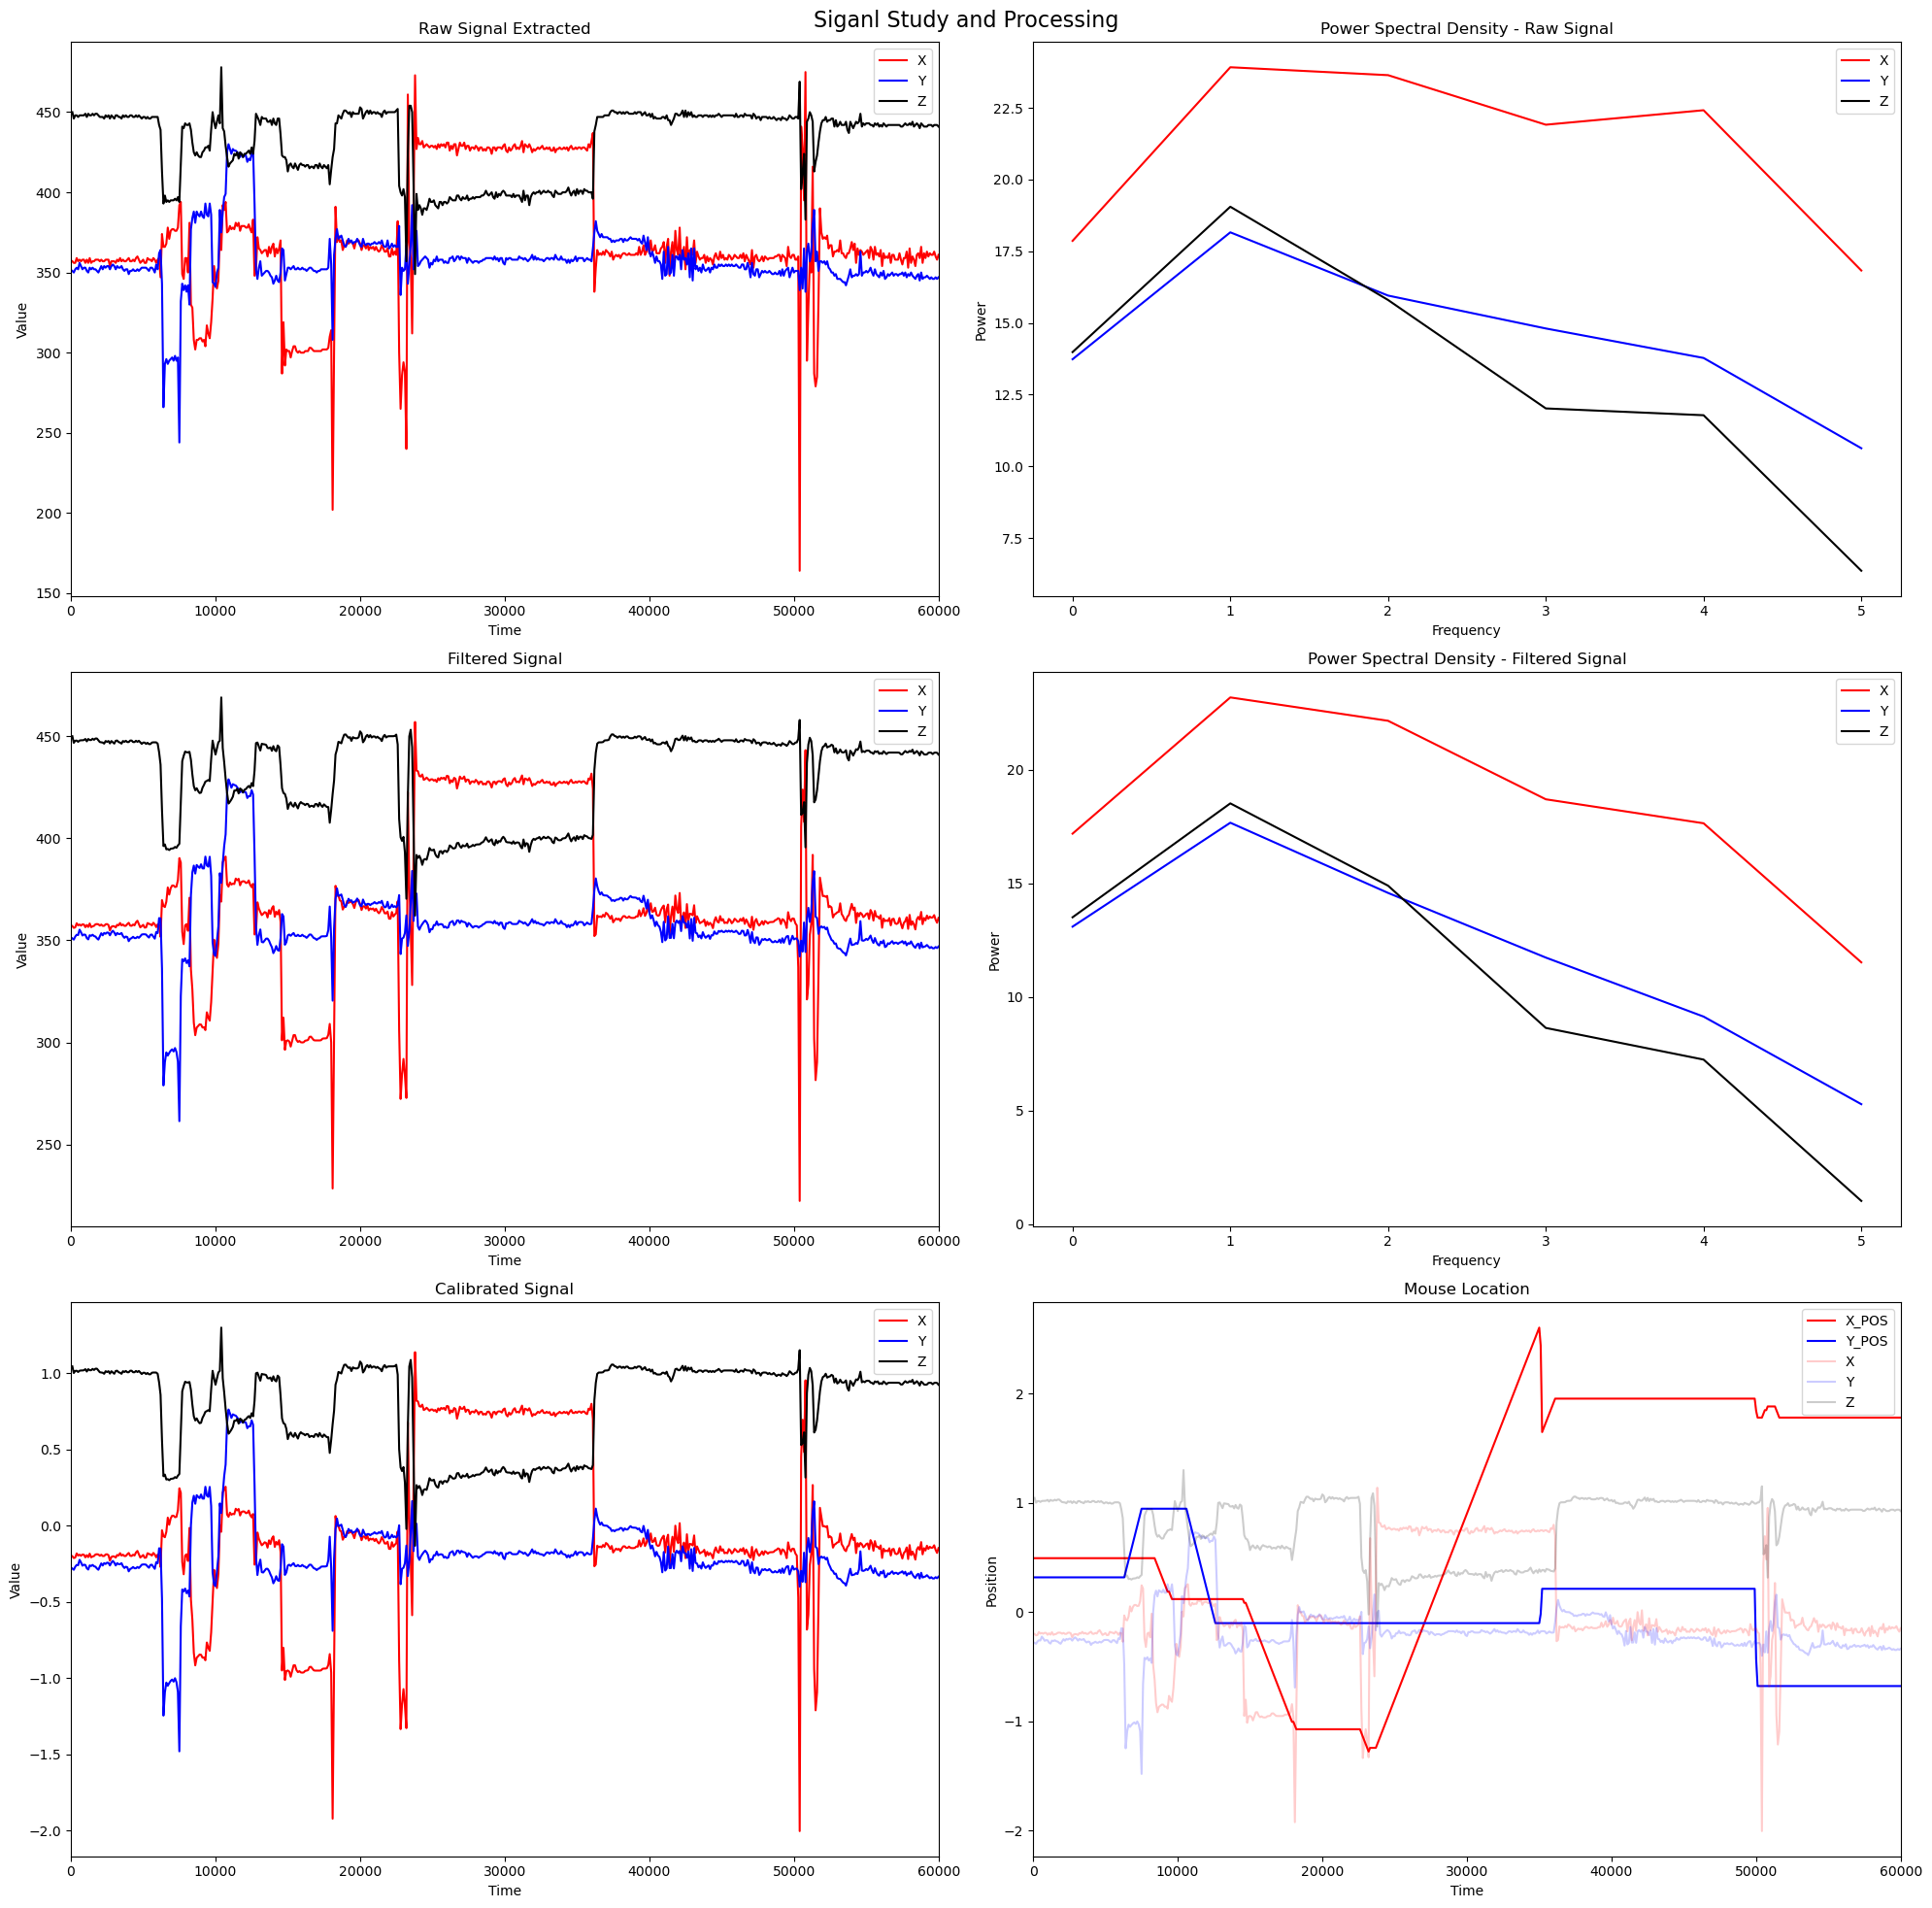

In [115]:
loadData("sensor_data_24-10-2023_16-28-11.txt", 10, 363.42857142857144, 391.14285714285717, 452.2857142857143, 
         cutoffFrequency=0.05,band='lowpass' ,interval=[0,60000])

351.4583333333333 349.0833333333333 447.9791666666667

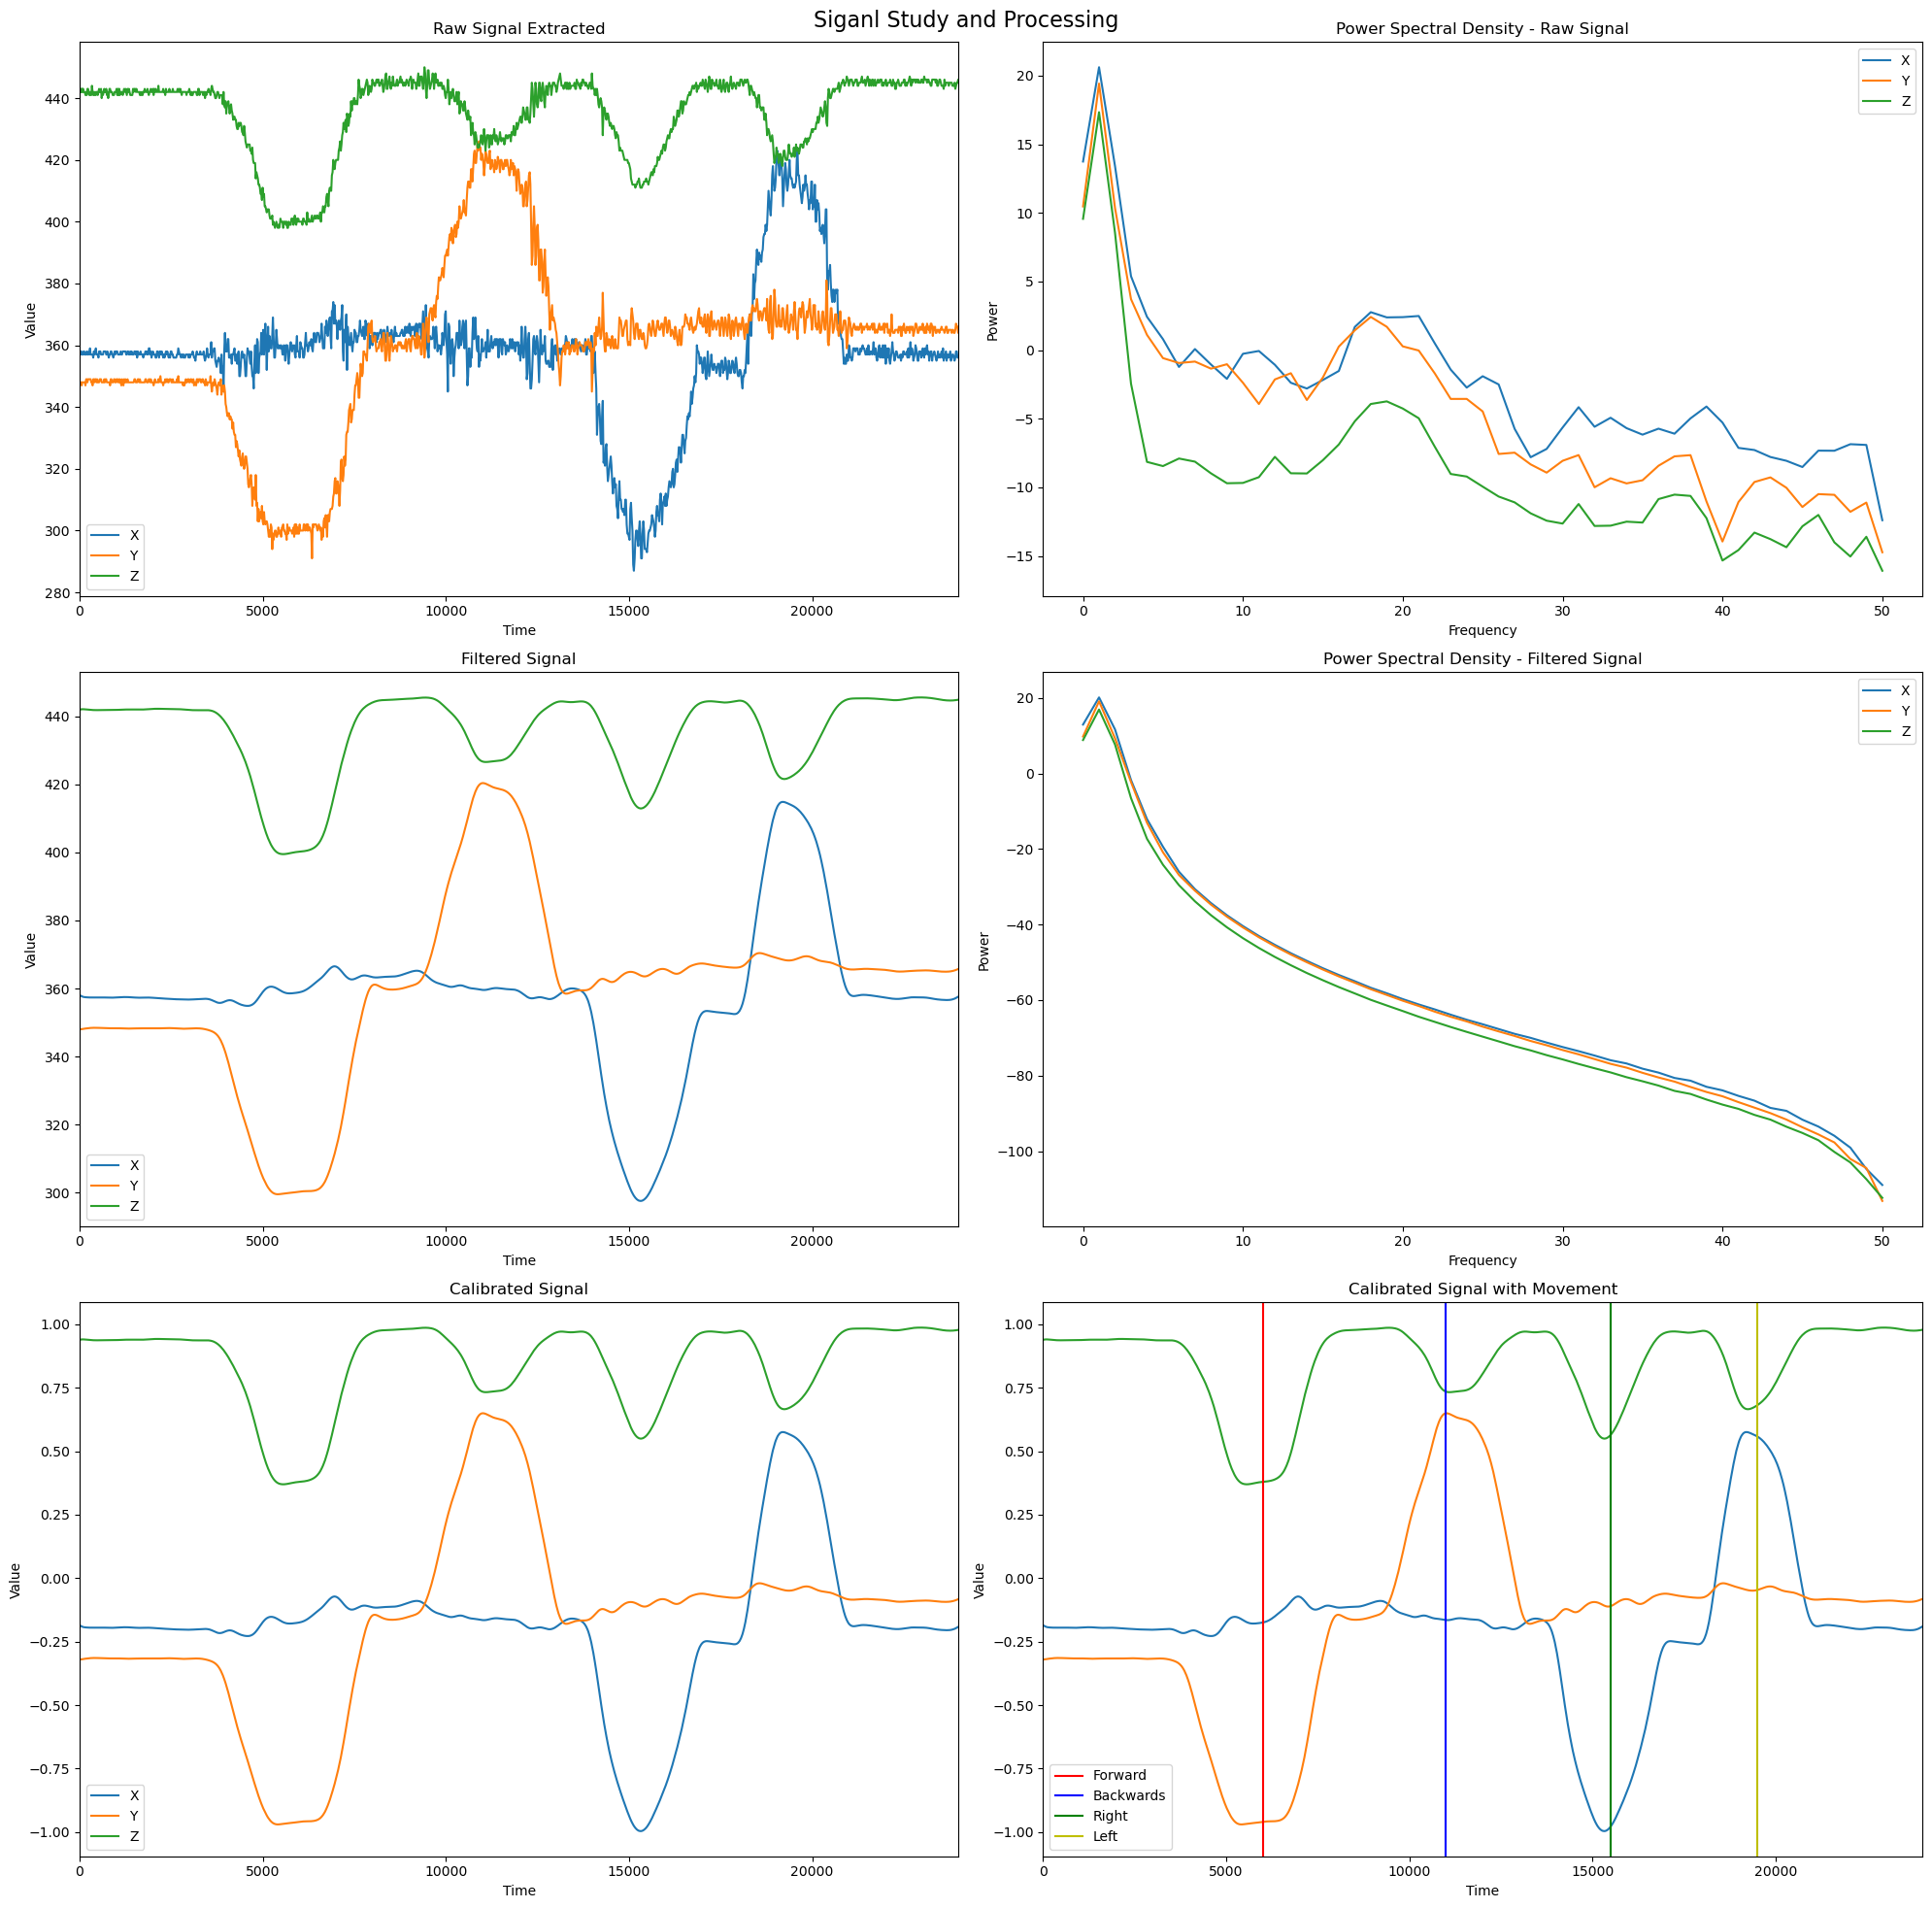

Session duration:  24.045 seconds


In [28]:
loadData("sensor_data_22-10-2023_16-52-46.txt", 100, cutoffFrequency=1, interval=[0,24000])

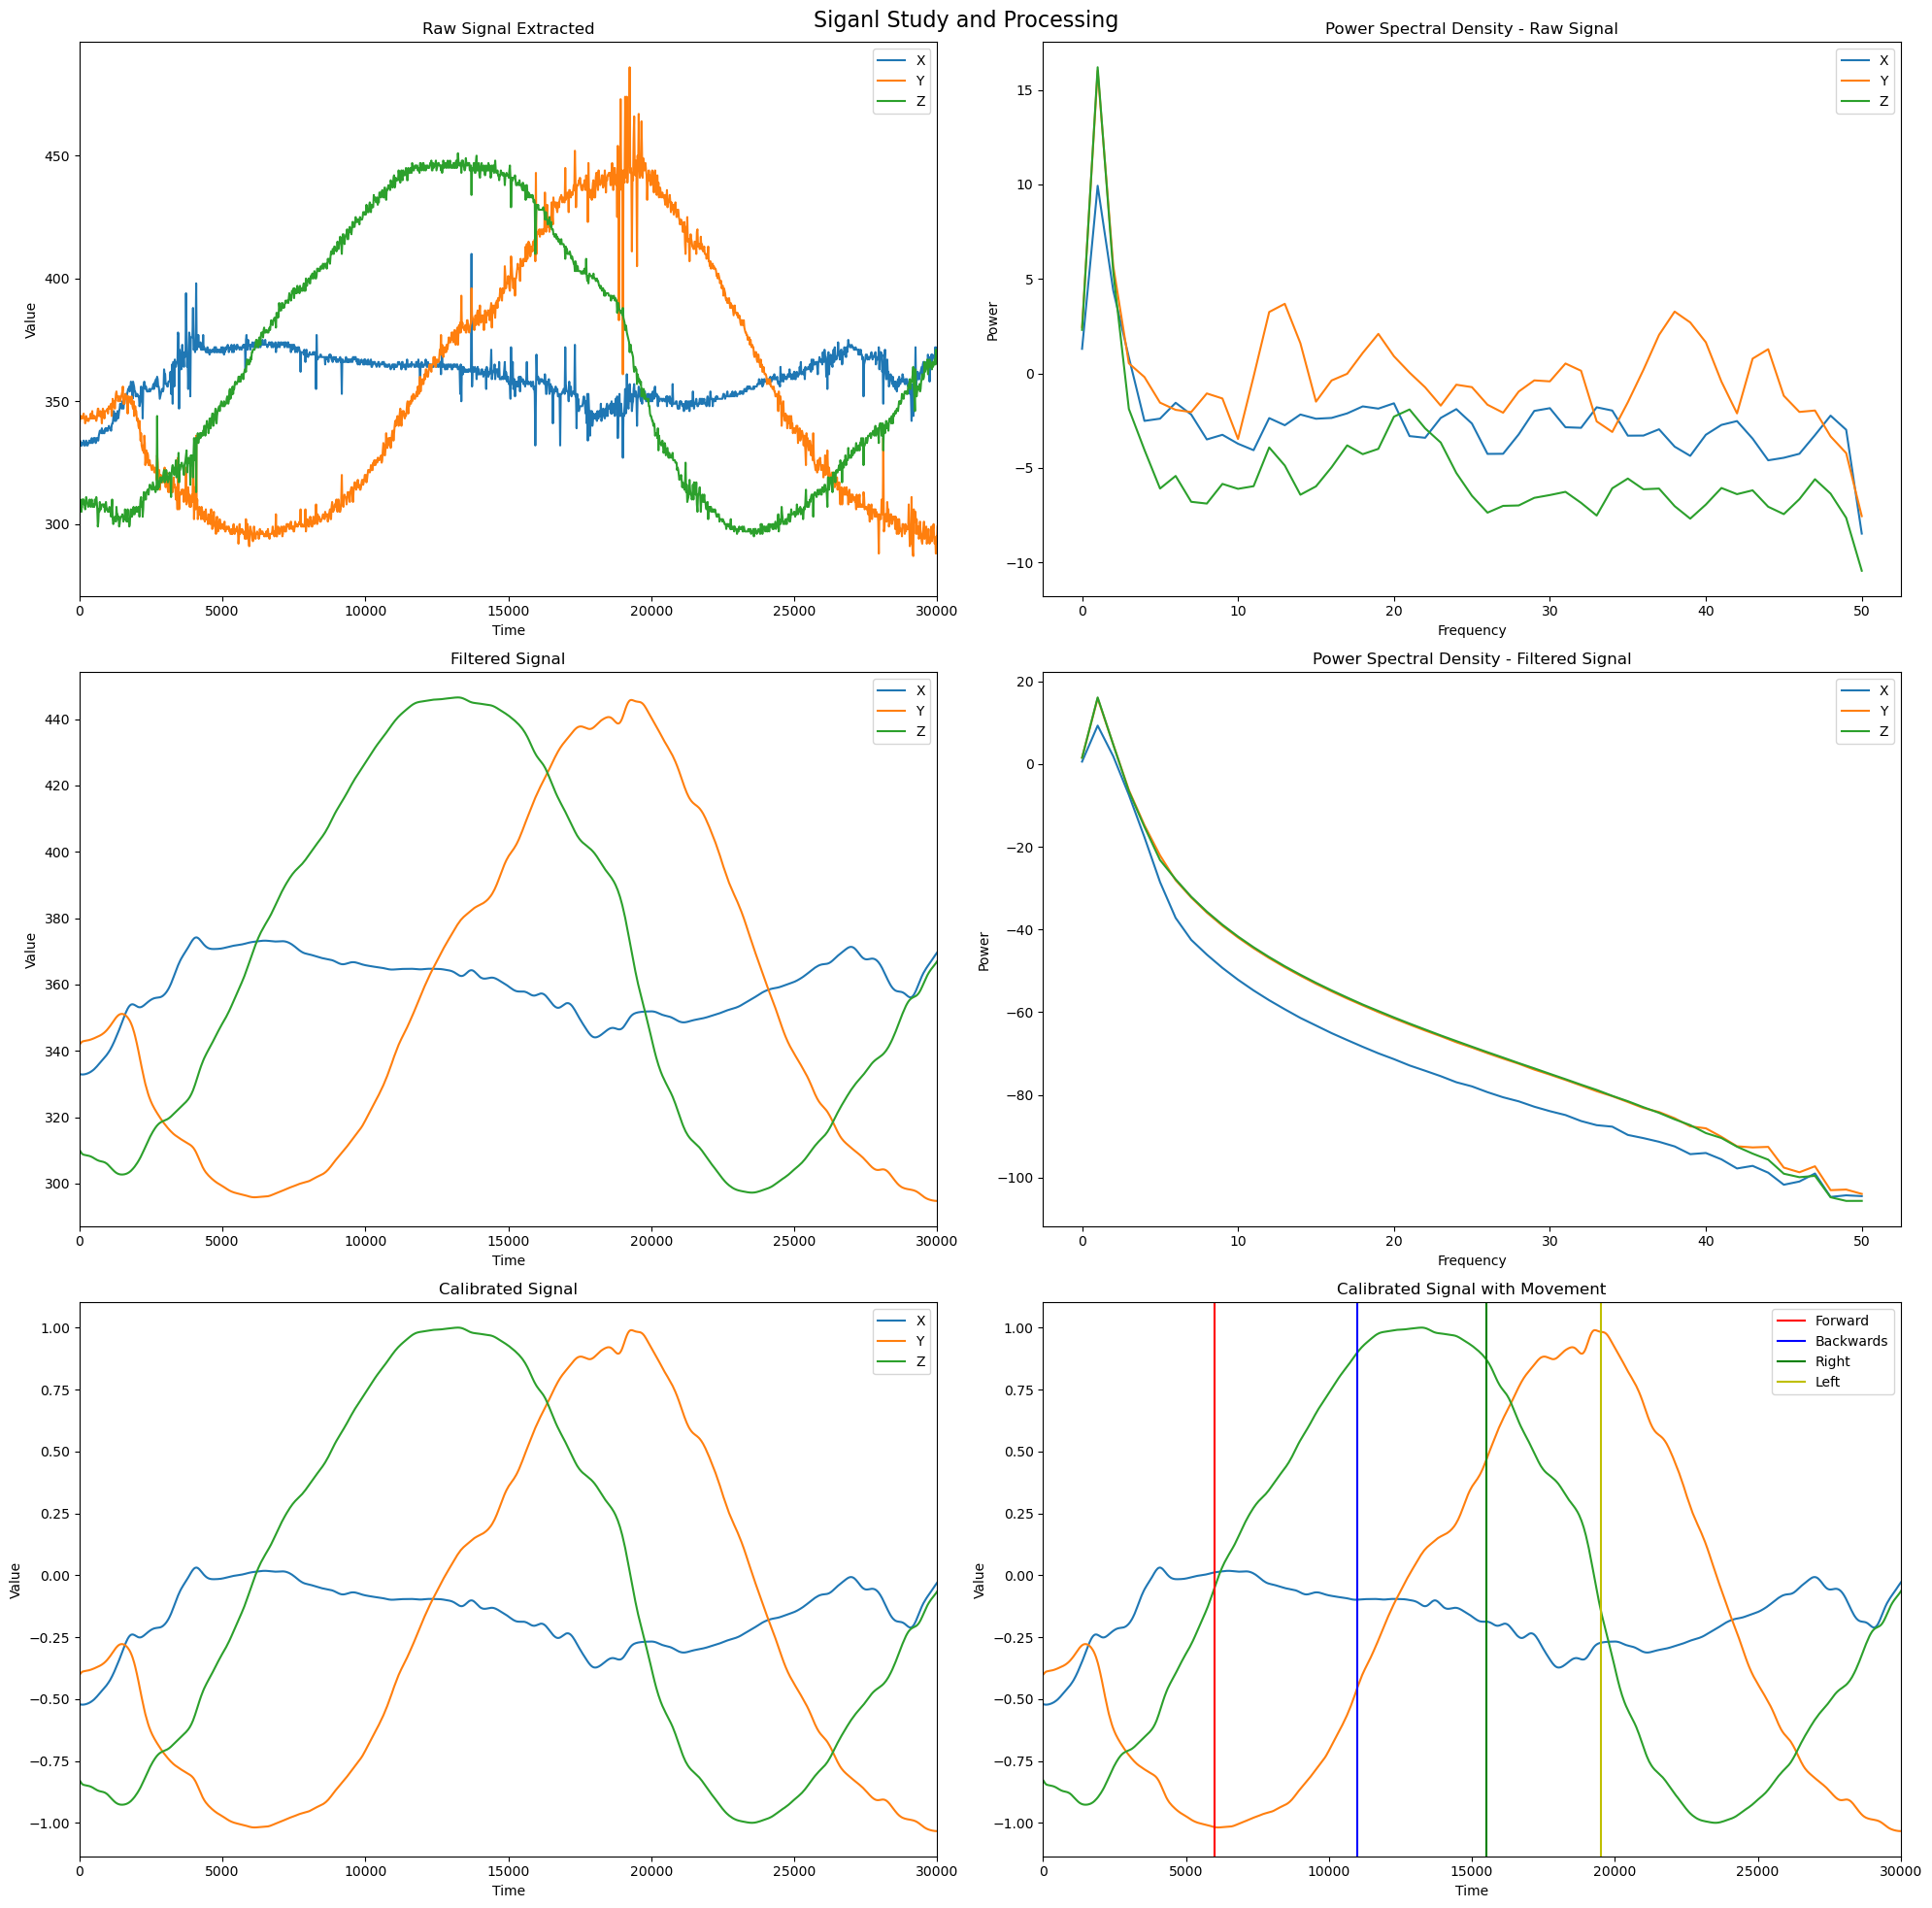

Session duration:  60.008 seconds


In [61]:
loadData("sensor_data_22-10-2023_03-13-08.txt", 100, cutoffFrequency=1, interval=[0,30000])

In [84]:
import numpy as np
import scipy.signal

def get_sma_cutoff(N, **kwargs):
    """
    Function for calculating the cut-off frequency of a 
    simple moving average filter. Uses the Newton-Raphson method to 
    converge to the correct solution.

    This function was initially written by Pieter P.
    (https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/
    Digital-filters/Simple%20Moving%20Average/Simple-Moving-Average.html).

    Args:
        N: Window size, in number of samples.

    Returns:
        The angular cut-off frequency, in rad/s.  
    """
    func = lambda w: np.sin(N*w/2) - N/np.sqrt(2) * np.sin(w/2)  # |H(e^jω)| = √2/2
    deriv = lambda w: np.cos(N*w/2) * N/2 - N/np.sqrt(2) * np.cos(w/2) / 2  # dfunc/dx
    omega_0 = np.pi/N  # Starting condition: halfway the first period of sin(Nω/2)
    return scipy.optimize.newton(func, omega_0, deriv, **kwargs)


In [123]:
get_sma_cutoff(3)

0.9756134771584428

In [124]:
get_sma_cutoff(2)

1.570796326794897